Colonnes du fichier Annotations: ['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']
Colonnes du fichier Bounding Boxes: ['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8']
Valeurs manquantes par colonne :
Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64
Nombre d'images par dossier :
{'D:\\PLUMOSCAN\\PulmoScan\\NIH_Chest_Data\\images_001\\images': 363, 'D:\\PLUMOSCAN\\PulmoScan\\N

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9880\381903504.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_labels.values, y=top_labels.index, palette="viridis")


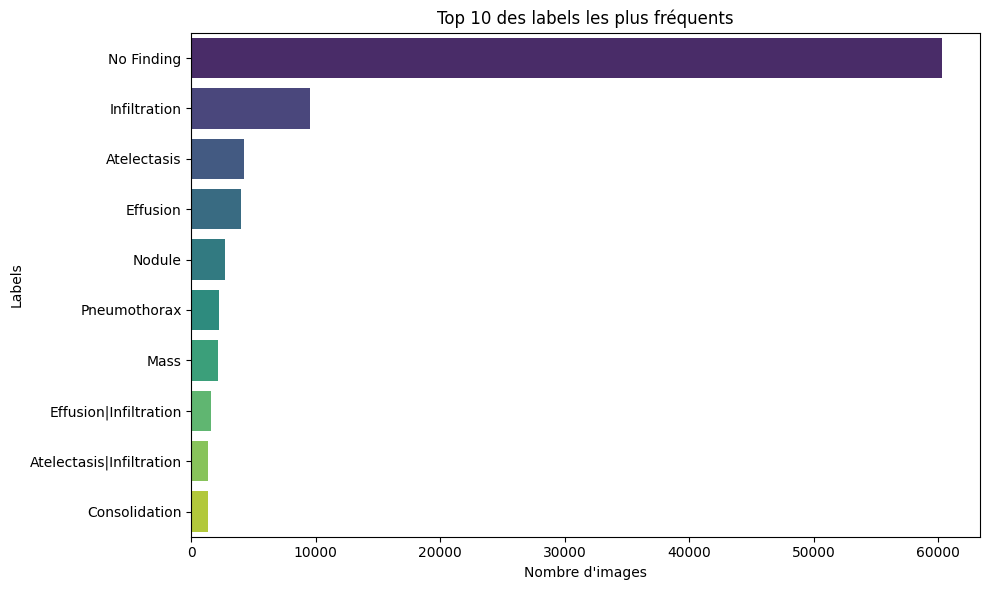

Nombre total d'images : 11207
Nombre de lots par époque : 351
Forme du lot d'images : (32, 224, 224, 1)
Forme du lot de labels : (32,)


In [10]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import ast
import seaborn as sns  # Ajout de Seaborn pour la visualisation

# Chemins des fichiers
BASE_DIR = r"D:\PLUMOSCAN\PulmoScan\NIH_Chest_Data"
CSV_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")
BBOX_CSV_PATH = os.path.join(BASE_DIR, "BBox_List_2017.csv")
IMAGE_DIRS = [os.path.join(BASE_DIR, f"images_{i:03}", "images") for i in range(1, 13)]

# 1. Afficher les colonnes des fichiers CSV
def display_csv_columns(csv_path, name):
    """
    Affiche les colonnes d'un fichier CSV.
    
    Args:
        csv_path (str): Chemin du fichier CSV.
        name (str): Nom du fichier CSV.
    """
    df = pd.read_csv(csv_path)
    print(f"Colonnes du fichier {name}: {df.columns.tolist()}")

# 2. Vérifier l'existence des valeurs manquantes et les générer si nécessaire
def handle_missing_values(df):
    """
    Vérifie et gère les valeurs manquantes dans un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame à vérifier.
    
    Returns:
        pd.DataFrame: DataFrame nettoyé.
    """
    print("Valeurs manquantes par colonne :")
    print(df.isnull().sum())
    
    # Supprimer les colonnes inutiles (exemple : colonnes vides)
    df.dropna(axis=1, how="all", inplace=True)
    return df

# 3. Prétraiter une image
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Charge et prétraite une image.
    
    Args:
        image_path (str): Chemin de l'image.
        target_size (tuple): Taille cible de l'image.
    
    Returns:
        np.array: Image prétraitée.
    """
    if not os.path.exists(image_path):
        print(f"Fichier non trouvé : {image_path}")
        return None
    
    try:
        img = load_img(image_path, target_size=target_size, color_mode="grayscale")
        img_array = img_to_array(img) / 255.0  # Normalisation
        return img_array
    except Exception as e:
        print(f"Erreur lors du chargement de {image_path}: {e}")
        return None

# 4. Compter le nombre d'images dans les différents dossiers
def count_images_in_dirs(image_dirs):
    """
    Compte le nombre d'images dans chaque dossier.
    
    Args:
        image_dirs (list): Liste des dossiers contenant les images.
    
    Returns:
        dict: Dictionnaire avec le nombre d'images par dossier.
    """
    image_counts = {}
    for dir_path in image_dirs:
        if os.path.exists(dir_path):
            image_counts[dir_path] = len([f for f in os.listdir(dir_path) if f.endswith(".png")])
        else:
            print(f"Dossier non trouvé : {dir_path}")
    return image_counts

# 5. Filtrer les annotations pour ne garder que les nodules et les masses
def filter_nodules_and_masses(annotations):
    """
    Filtre les annotations pour ne garder que les nodules et les masses.
    
    Args:
        annotations (pd.DataFrame): DataFrame contenant les annotations.
    
    Returns:
        pd.DataFrame: DataFrame filtré.
    """
    nodule_mass_data = annotations[annotations["Finding Labels"].str.contains("Nodule|Mass")]
    nodule_mass_data = nodule_mass_data[~nodule_mass_data["Finding Labels"].str.contains("Infiltrate")]
    return nodule_mass_data

# 6. Afficher le nombre de nodules et de masses par rapport aux autres labels
def count_labels(annotations):
    """
    Compte le nombre de nodules et de masses par rapport aux autres labels.
    
    Args:
        annotations (pd.DataFrame): DataFrame contenant les annotations.
    """
    label_counts = annotations["Finding Labels"].value_counts()
    print("Nombre de labels :")
    print(label_counts)

# 7. Visualiser la distribution des labels
def visualize_top_labels_horizontal(annotations, top_n=10):
    """
    Visualise les top_n labels les plus fréquents avec un graphique à barres horizontales.
    
    Args:
        annotations (pd.DataFrame): DataFrame contenant les annotations.
        top_n (int): Nombre de labels les plus fréquents à afficher.
    """
    label_counts = annotations['Finding Labels'].value_counts()
    top_labels = label_counts[:top_n]
    
    # Afficher la distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_labels.values, y=top_labels.index, palette="viridis")
    plt.title(f"Top {top_n} des labels les plus fréquents")
    plt.xlabel("Nombre d'images")
    plt.ylabel("Labels")
    plt.tight_layout()
    plt.show()
    
# 8. Générateur de données personnalisé
class DataGenerator:
    def __init__(self, annotations, image_dirs, batch_size=32, target_size=(224, 224), shuffle=True):
        """
        Initialise le générateur de données.
        
        Args:
            annotations (pd.DataFrame): DataFrame contenant les annotations.
            image_dirs (list): Liste des dossiers contenant les images.
            batch_size (int): Taille du lot (batch).
            target_size (tuple): Taille cible des images.
            shuffle (bool): Si True, mélange les données à chaque époque.
        """
        self.annotations = annotations
        self.image_dirs = image_dirs
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        
        # Lister tous les fichiers images avec leurs annotations
        self.image_paths = []
        self.labels = []
        for dir_path in image_dirs:
            if os.path.exists(dir_path):
                for img_name in os.listdir(dir_path):
                    if img_name.endswith(".png") and img_name in annotations["Image Index"].values:
                        img_path = os.path.join(dir_path, img_name)
                        self.image_paths.append(img_path)
                        label = annotations[annotations["Image Index"] == img_name]["Finding Labels"].values[0]
                        self.labels.append(1 if "Nodule" in label or "Mass" in label else 0)
        
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def on_epoch_end(self):
        """Mélange les indices à la fin de chaque époque."""
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        """Retourne le nombre de lots par époque."""
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """Génère un lot de données."""
        # Sélectionner les indices pour ce lot
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Initialiser les tableaux pour les images et les labels
        images = []
        labels = []

        # Charger les images et les labels pour ce lot
        for i in batch_indexes:
            img_path = self.image_paths[i]
            label = self.labels[i]
            try:
                img_array = preprocess_image(img_path, target_size=self.target_size)
                if img_array is not None:
                    images.append(img_array)
                    labels.append(label)
            except Exception as e:
                print(f"Erreur lors du chargement de {img_path}: {e}")

        # Convertir en tableaux numpy
        images = np.array(images)
        labels = np.array(labels)
        
        return images, labels

# 9. Supprimer les images qui n'ont pas d'annotations
def delete_images_without_annotations(annotations, image_dirs):
    """
    Supprime les images qui n'ont pas d'annotations.
    
    Args:
        annotations (pd.DataFrame): DataFrame contenant les annotations.
        image_dirs (list): Liste des dossiers contenant les images.
    """
    for dir_path in image_dirs:
        if os.path.exists(dir_path):
            for img_name in os.listdir(dir_path):
                if img_name.endswith(".png") and img_name not in annotations["Image Index"].values:
                    img_path = os.path.join(dir_path, img_name)
                    os.remove(img_path)
                    print(f"Image supprimée : {img_path}")

# Fonction principale
def main():
    # 1. Afficher les colonnes des fichiers CSV
    display_csv_columns(CSV_PATH, "Annotations")
    display_csv_columns(BBOX_CSV_PATH, "Bounding Boxes")
    
    # 2. Charger les annotations et gérer les valeurs manquantes
    annotations = pd.read_csv(CSV_PATH)
    annotations = handle_missing_values(annotations)
    
    # 3. Compter le nombre d'images dans les différents dossiers
    image_counts = count_images_in_dirs(IMAGE_DIRS)
    print("Nombre d'images par dossier :")
    print(image_counts)
    
    # 4. Filtrer les annotations pour ne garder que les nodules et les masses
    nodule_mass_data = filter_nodules_and_masses(annotations)
    
    # 5. Afficher le nombre de nodules et de masses par rapport aux autres labels
    count_labels(annotations)
    
    # 6. Visualiser la distribution des labels
    visualize_top_labels_horizontal(annotations, top_n=10)    
    # 7. Créer le générateur de données
    batch_size = 32
    target_size = (224, 224)
    train_generator = DataGenerator(nodule_mass_data, IMAGE_DIRS, batch_size=batch_size, target_size=target_size)
    
    # 8. Afficher des informations sur les données
    print(f"Nombre total d'images : {len(train_generator.image_paths)}")
    print(f"Nombre de lots par époque : {len(train_generator)}")
    
    # 9. Exemple d'utilisation du générateur
    for batch_images, batch_labels in train_generator:
        print(f"Forme du lot d'images : {batch_images.shape}")
        print(f"Forme du lot de labels : {batch_labels.shape}")
        break  # Afficher uniquement le premier lot
    
    # 10. Supprimer les images qui n'ont pas d'annotations
    delete_images_without_annotations(nodule_mass_data, IMAGE_DIRS)

if __name__ == "__main__":
    main()